## Preamble


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/python/BayesianFiltering

/content/drive/MyDrive/python/BayesianFiltering


In [3]:
%%capture
!pip install jaxtyping dynamax
!pip install -U jax jaxlib
!pip install -U jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [4]:
from jax import numpy as jnp
from jax import jacfwd, jacrev, jit, vmap, lax, make_jaxpr
from jax import random as jr
from jax import tree_util as jtu
import jax
from functools import partial
import tensorflow

import gaussfiltax.utils as utils
import gaussfiltax.containers as containers
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
import gaussfiltax.particlefilt as pf
from gaussfiltax.models import ParamsNLSSM, NonlinearGaussianSSM, NonlinearSSM, ParamsBPF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import set_matplotlib_formats
plt.rcParams['svg.fonttype'] = 'none'
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Models and simulations

In [6]:
# Parameters
state_dim = 3
state_noise_dim = 3
emission_dim = 3
emission_noise_dim = 3
seq_length = 100
mu0 = 1.0 * jnp.zeros(state_dim)
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.ones(emission_noise_dim)
Sigma0 = 1.0 * jnp.eye(state_dim)
Q = 20.0 * jnp.eye(state_noise_dim)
R = .1 * jnp.eye(emission_noise_dim)

# ICASSP
f1 = lambda x, q, u: (1-u) * x / 2.  + u * jnp.sin(10 * x) + q
g1 = lambda x, r, u:  1.0 * jnp.dot(x, x) + r
def g1lp(x,y,u):
    return MVN(loc = g1(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Lorenz 63
def lorentz_63(x, sigma=10, rho=28, beta=2.667, dt=0.01):
    dx = dt * sigma * (x[1] - x[0])
    dy = dt * (x[0] * rho - x[1] - x[0] *x[2]) 
    dz = dt * (x[0] * x[1] - beta * x[2])
    return jnp.array([dx+x[0], dy+x[1], dz+x[2]])
f63 = lambda x, q, u: lorentz_63(x) + q

# Lorentz 96
alpha = 1.0
beta = 1.0
gamma = 8.0
dt = 0.01
H = jnp.zeros((emission_dim,state_dim))
for row in range(emission_dim):
    col = 2*row
    H = H.at[row,col].set(1.0)
CP = lambda n: jnp.block([[jnp.zeros((1,n-1)), 1.0 ],[jnp.eye(n-1), jnp.zeros((n-1,1))]])
A = CP(state_dim)
B = jnp.power(A, state_dim-1) - jnp.power(A, 2)
f96 = lambda x, q, u: x + dt * (alpha * jnp.multiply(A @ x, B @ x) - beta * x + gamma * jnp.ones(state_dim)) + q
g96 = lambda x, r, u: H @ x + r
def g96lp(x,y,u):
  return MVN(loc = g96(x, 0.0, u), covariance_matrix = R).log_prob(y)

# stochastic growth model
f3 = lambda x, q, u: x / 2. + 25. * x / (1 + jnp.power(x, 2)) * u + q
g3 = lambda x, r, u: 0.8 * x + r
def g3lp(x,y,u):
    return MVN(loc = g3(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Stochastic Volatility
alpha = 0.91
sigma = 1.0
beta = 0.5
fsv= lambda x, q, u: alpha * x + sigma * q
gsv = lambda x, r, u: beta * jnp.exp(x/2) * r
def svlp(x,y,u):
    return MVN(loc = gsv(x, r0, u), covariance_matrix = gsv(x, 1.0, u)**2 * R).log_prob(y)

# Linear - Stochastic Volatility
alpha = 0.91
sigma = 1.0
beta = 0.5
glsv = lambda x, r, u: u * beta * jnp.exp(x/2) * r + (1-u) * (0.8 * x + r)
def lsvlp(x,y,u):
    return MVN(loc = glsv(x, r0, u), covariance_matrix = u * beta ** 2 * jnp.exp(x) * R + (1-u) * R).log_prob(y)

# Multivariate SV
Phi = 0.8 * jnp.eye(state_dim)
fmsv = lambda x, q, u: Phi @ x +  q #((1-u) + 0.3*u)*q
gmsv = lambda x, r, u:  u * 0.5 * jnp.multiply(jnp.exp(x/2), r)
def msvlp(x,y,u):
    return MVN(loc = gmsv(x, r0, u), covariance_matrix = jnp.diag(jnp.exp(x/2.0)) @ R @ jnp.diag(jnp.exp(x/2.0))).log_prob(y)

# Linear - Multivariate SV
alpha = 0.91
sigma = 5.0
beta = 0.5

H = jnp.eye(emission_dim,state_dim)
# for row in range(emission_dim):
#     col = 2*row
#     H = H.at[row,col].set(1.0)
# H = 0.1 * H
glmsv = lambda x, r, u: u * 0.5 * jnp.multiply(jnp.exp(x / sigma), r) + (1-u) * (H @ x + r)
def lmsvlp(x,y,u):
    M = u * 0.5 * jnp.diag(jnp.exp(x / sigma)) + (1-u) * H
    return MVN(loc = glmsv(x, r0, u), covariance_matrix = M @ R @ M.T).log_prob(y)


# Inputs
# inputs = 1. * jnp.cos(0.1 * jnp.arange(seq_length))
sm = lambda x : jnp.exp(x) / (1+jnp.exp(x))
# inputs = sm(jnp.arange(seq_length)-50) # off - on gradually
inputs = jnp.array([0]*int(seq_length/2) + [1]*int(seq_length/2)) # off - on
# inputs = 0.0 * jnp.ones(seq_length) # on - on
# inputs = 1.0 * jnp.ones(seq_length) # on - on

In [7]:
f = fmsv
g = glmsv
glp = lmsvlp

In [8]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

In [ ]:
verbose = False
Nsim = 100
gsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)
gsf_time = jnp.zeros(Nsim)
agsf_time = jnp.zeros(Nsim)
bpf_time = jnp.zeros(Nsim)
gsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))
Deltas_avg_trace = jnp.zeros((seq_length, ))
Lambdas_avg_trace = jnp.zeros((seq_length, ))
keys = []
next_key = jr.PRNGKey(0)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key, next_key = jr.split(next_key)
    states, emissions = model.sample(params, key, seq_length, inputs = inputs)
    keys.append(key)
    

    # GSF
    M = 5
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    gsf_time = gsf_time.at[i].set(tout - tin)
    print('       Time taken for GSF: ', tout - tin)

    # AGSF
    tin = time.time()
    num_components = [M, 3, 6] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = (0.8, 10.0), inputs=inputs)    
    Deltas_avg_trace += jnp.trace(aux_outputs["Deltas"], axis1=2, axis2=3).sum(axis=1) / Nsim
    Lambdas_avg_trace += jnp.trace(aux_outputs["Lambdas"], axis1=2, axis2=3).sum(axis=1) / Nsim
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    agsf_time = agsf_time.at[i].set(tout - tin)
    print('       Time taken for AGSF: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 100

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    bpf_time = bpf_time.at[i].set(tout - tin)
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf - states, axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf - states, axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf - states, axis = 1))

    gsf_rmse = gsf_rmse.at[i].set(gsf_norm[i].sum() / seq_length)
    agsf_rmse = agsf_rmse.at[i].set(agsf_norm[i].sum() / seq_length)
    bpf_rmse = bpf_rmse.at[i].set(bpf_norm[i].sum() / seq_length)

    print('              GSF RMSE:', gsf_rmse[i])
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])




sim 1/100
       Time taken for GSF:  0.8007051944732666
       Time taken for AGSF:  9.875589370727539
       Time taken for BPF:  0.928170919418335
              GSF RMSE: 4.9466977
              AGSF RMSE: 2.0093381
              BPF RMSE: 2.8494964
sim 2/100
       Time taken for GSF:  0.700477123260498
       Time taken for AGSF:  4.066755533218384
       Time taken for BPF:  0.9179952144622803
              GSF RMSE: 3.8426018
              AGSF RMSE: 1.8628472
              BPF RMSE: 2.7752147
sim 3/100
       Time taken for GSF:  0.7561283111572266
       Time taken for AGSF:  4.15887975692749
       Time taken for BPF:  0.8865594863891602
              GSF RMSE: 7.0666986
              AGSF RMSE: 2.1592383
              BPF RMSE: 3.1510546
sim 4/100
       Time taken for GSF:  0.7432758808135986
       Time taken for AGSF:  4.093951940536499
       Time taken for BPF:  0.9119982719421387
              GSF RMSE: 4.8230796
              AGSF RMSE: 2.4489076
              BPF RMS

In [65]:
ind = jnp.argwhere(jnp.isnan(gsf_norm[:,99])).flatten()
gsf_norm = jnp.delete(gsf_norm, ind, axis = 0)

In [66]:
import pandas as pd
gsf_armse = jnp.mean(gsf_rmse)
agsf_armse = jnp.mean(agsf_rmse)
bpf_armse = jnp.mean(bpf_rmse)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_rmse))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_rmse))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_rmse))

# gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, np.std(gsf_time))
# agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, np.std(agsf_time))
# bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, np.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
df[' '] = ['GSF', 'AGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, agsf_tab_out, bpf_tab_out]
#  df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))  
df

\begin{tabular}{lll}
\toprule
     &                  RMSE & time(s) \\
\midrule
 GSF &       4.27±      1.00 &     NaN \\
AGSF &       2.14±      0.20 &     NaN \\
 BPF &       2.91±      0.19 &     NaN \\
\bottomrule
\end{tabular}



<ipython-input-66-84c30aa12b10>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


,,RMSE,time(s)
0,GSF,4.27± 1.00,NaN
1,AGSF,2.14± 0.20,NaN
2,BPF,2.91± 0.19,NaN


## Plots

In [67]:
# plots preamble
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 2

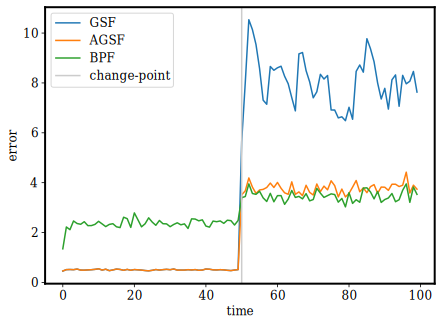

In [68]:
plt.figure(figsize=(7, 5))
plt.plot(gsf_norm.sum(axis=0)/(Nsim-len(ind)) , label = 'GSF')
plt.plot(agsf_norm.sum(axis=0)/Nsim, label = 'AGSF')
plt.plot(bpf_norm.sum(axis=0)/Nsim, label = 'BPF')
plt.axvline(x=50, color = '0.8', label='change-point')
plt.xlabel('time')
plt.ylabel('error')
plt.legend()
plt.savefig('/content/drive/MyDrive/python/BayesianFiltering/output/adaptive_fig.eps', format='eps', bbox_inches = 'tight')
plt.show()

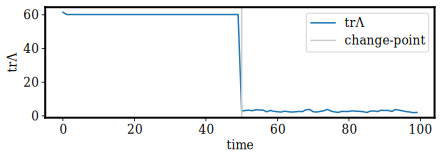

In [69]:
# plot Lambdas
plt.figure(figsize=(7, 2))
plt.plot(Lambdas_avg_trace/15, label='trΛ')
plt.axvline(x=50, color = '0.8', label='change-point')
plt.xlabel('time')
plt.ylabel('trΛ')
plt.legend()
plt.savefig('/content/drive/MyDrive/python/BayesianFiltering/output/lambda_fig.eps', format='eps', bbox_inches = 'tight')

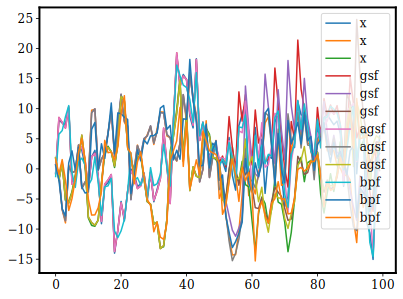

In [70]:
plt.plot(states, label = 'x')
plt.plot(point_estimate_gsf, label = 'gsf')
plt.plot(point_estimate_agsf, label = 'agsf')
plt.plot(point_estimate_bpf, label = 'bpf')
plt.legend()
plt.show()

### GSF

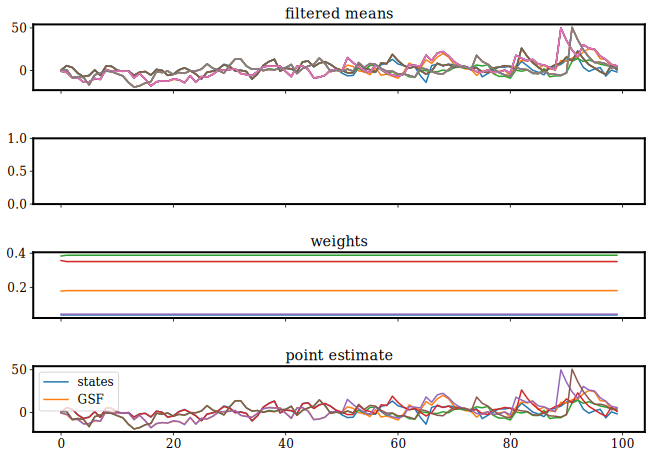

In [62]:
num_components = M

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_gsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")
#axes[0].legend(leg)

if state_dim ==1:
    for m in range(M):
        axes[1].plot(posterior_filtered_gsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

for m in range(M):
    axes[2].plot(posterior_filtered_gsf.weights[m])
    axes[2].set_title("weights")

axes[3].plot(states, label="xs")
leg = ["states", "GSF"]
axes[3].plot(point_estimate_gsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")
plt.show()

### AGSF

TypeError: ignored

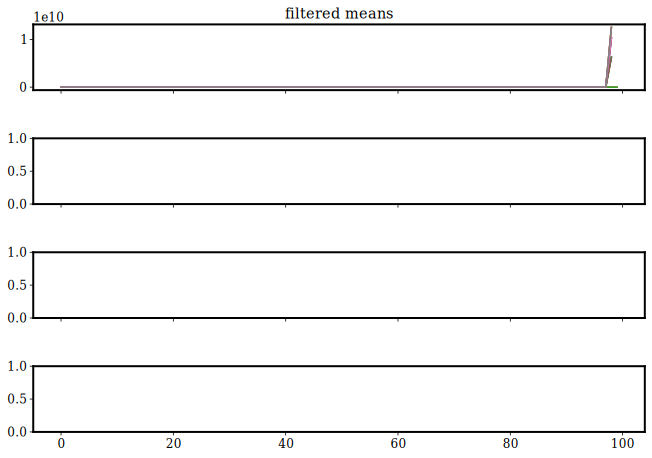

In [61]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_agsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")

#axes[0].legend(leg)

if state_dim == 1:
    for m in range(M):
        axes[1].plot(posterior_filtered_agsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

else:
    for m in range(jnp.prod(num_components)):
        axes[1].plot(aux_outputs["updated_means"][:,m])
        axes[1].set_title("updated means")

for m in range(jnp.prod(num_components)):
        axes[2].plot(aux_outputs["pre_weights"][:,m])
        axes[2].set_title("updated pre_weights")

axes[3].plot(states, label="xs")
leg = ["states", "AGSF"]
axes[3].plot(point_estimate_agsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")

plt.show()

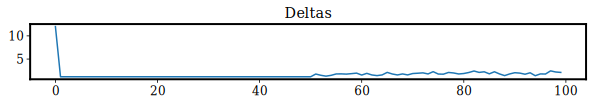

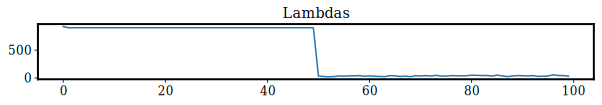

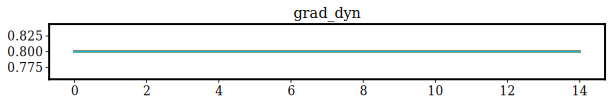

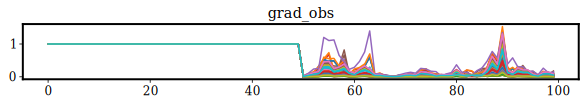

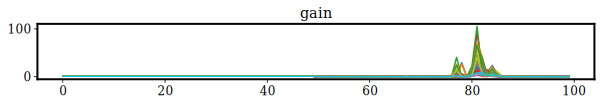

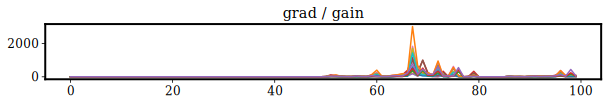

In [18]:
# plot Deltas
plt.figure(figsize=(10, 1))
plt.plot(Deltas_avg_trace)
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
plt.plot(Lambdas_avg_trace)
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[1]):
    plt.plot(aux_outputs["grads_obs"][:, i, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[1]):
    plt.plot(aux_outputs["gain"][:, i, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[1]):
    plt.plot(aux_outputs["grads_dyn"][:, i, 0, 0] / aux_outputs["gain"][:, i * 3, 0, 0])
plt.title('grad / gain')
plt.show()

In [19]:
aux_outputs['Deltas'][50]

Array([[[0.07960358, 0.        , 0.        ],
        [0.        , 0.07960358, 0.        ],
        [0.        , 0.        , 0.07960358]],

       [[0.07960358, 0.        , 0.        ],
        [0.        , 0.07960358, 0.        ],
        [0.        , 0.        , 0.07960358]],

       [[0.07960358, 0.        , 0.        ],
        [0.        , 0.07960358, 0.        ],
        [0.        , 0.        , 0.07960358]],

       [[0.07960358, 0.        , 0.        ],
        [0.        , 0.07960358, 0.        ],
        [0.        , 0.        , 0.07960358]],

       [[0.07960358, 0.        , 0.        ],
        [0.        , 0.07960358, 0.        ],
        [0.        , 0.        , 0.07960358]]], dtype=float32)

### BPF

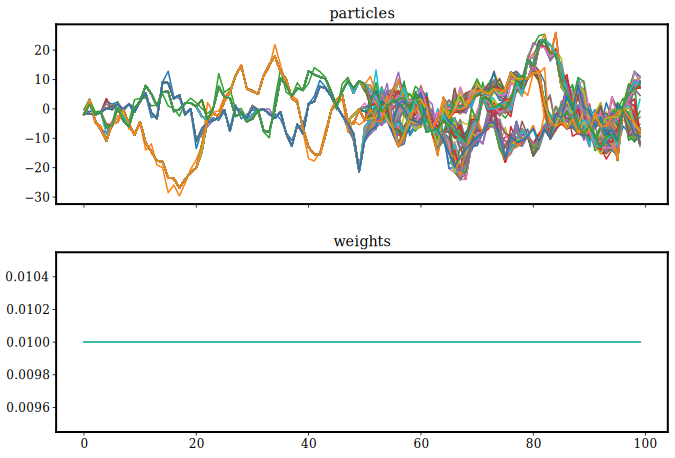

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(num_particles):
    axes[0].plot(posterior_bpf["particles"][m])
    leg.append("model {}".format(m))
    axes[0].set_title("particles")

for m in range(num_particles):
    axes[1].plot(posterior_bpf["weights"][m])
    axes[1].set_title("weights")

plt.show()